# Sensor Understanding & Selection

### Load the cleaned data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../data/train_FD001_clean.csv")


### Sanity check

In [3]:
df.head()
df.shape

(20631, 26)

### Understand fleet & time behavior

In [4]:
#Engines and cycles

df["engine_id"].nunique()  # Number of unique engines should be 100

#Check life length variability

df.groupby("engine_id")["cycle"].max().describe() # Life lengths vary across engines

count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: cycle, dtype: float64

In [5]:
from pathlib import Path
import sys

src_path = (Path("..") / "src").resolve()
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from utils import ensure_life_frac, degradation_indicators, rank_sensors_by_degradation

test_df = ensure_life_frac(df)
test_df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,life_frac
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,0.005208
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0.010417
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0.015625
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0.020833
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0.026042


### Quick sensor variability scan Across Fleet

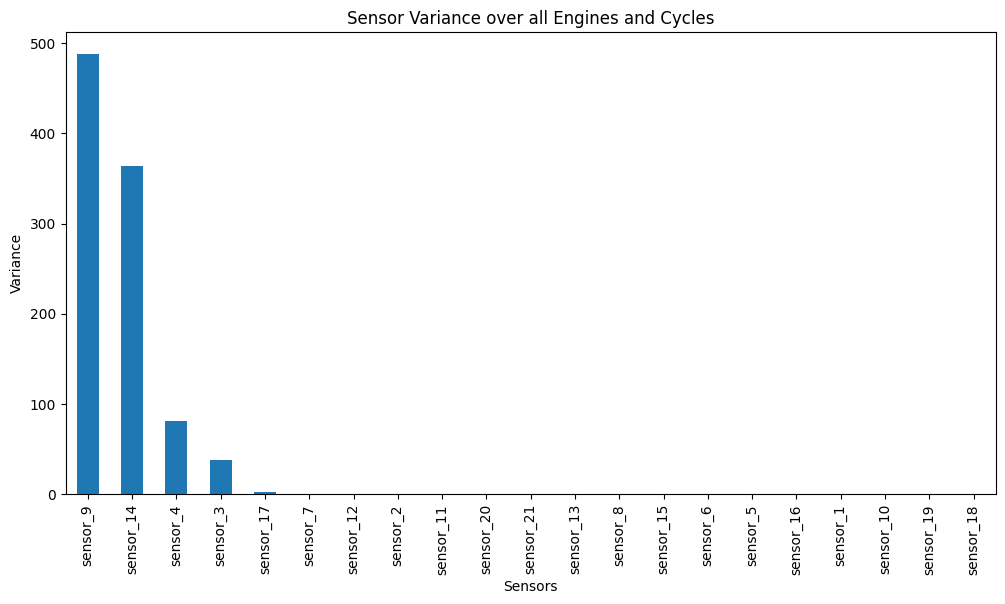

In [6]:
# We want to identify:

# - Sensors that change over life
# - Sensors that are nearly constant

sensor_cols = [c for c in df.columns if c.startswith("sensor_")]

sensor_variance = df[sensor_cols].var().sort_values(ascending=False)

sensor_variance.plot(kind="bar", figsize=(12, 6))
plt.title("Sensor Variance over all Engines and Cycles")
plt.ylabel("Variance")
plt.xlabel("Sensors")
plt.show()

# sensor_9, sensor_14, sensor_4, sensor_3 have high variance in order


In [7]:
# Step 2 (diagnostically correct): use normalized life, not raw cycle, for fleet comparisons
from pathlib import Path
import sys

src_path = (Path("..") / "src").resolve()
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from utils import ensure_life_frac, degradation_indicators, rank_sensors_by_degradation

df = ensure_life_frac(df)

# Select a sensor consistently for the next diagnostics (no hardcoding)
sensor_cols = [c for c in df.columns if c.startswith("sensor_")]
sensor_variance = df[sensor_cols].var().sort_values(ascending=False)
selected_sensor = sensor_variance.index[0]

# Pick an engine_id to analyze (e.g., the first one)
engine_id = 10  # or set to any valid engine ID you want to analyze

# Keep a sorted view for time-based operations
df_e = df[df["engine_id"] == engine_id].sort_values("cycle").copy()
selected_sensor

'sensor_9'

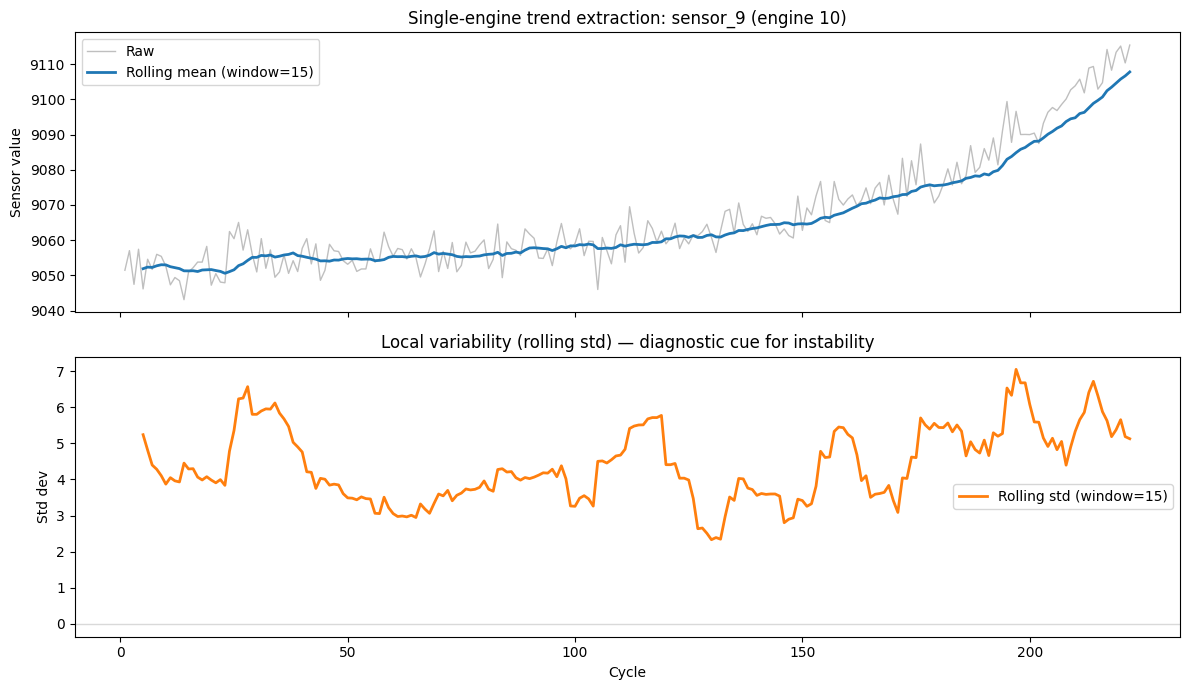

In [8]:
# 1) Single-engine rolling mean/std: extract slow drift + local instability without assuming sharp changes

# Window choice: large enough to suppress cycle-to-cycle noise, small enough to keep trends visible
window = max(12, int(df_e["cycle"].max() * 0.07))  # ~7% of engine life (practical heuristic)
min_periods = max(5, window // 3)  # avoid misleading values at the start

df_e["roll_mean"] = df_e[selected_sensor].rolling(window=window, min_periods=min_periods).mean()
df_e["roll_std"] = df_e[selected_sensor].rolling(window=window, min_periods=min_periods).std()

fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

# Raw + rolling mean: highlights slow degradation drift if present
axes[0].plot(df_e["cycle"], df_e[selected_sensor], color="0.75", linewidth=1, label="Raw")
axes[0].plot(df_e["cycle"], df_e["roll_mean"], color="C0", linewidth=2, label=f"Rolling mean (window={window})")
axes[0].set_title(f"Single-engine trend extraction: {selected_sensor} (engine {engine_id})")
axes[0].set_ylabel("Sensor value")
axes[0].legend(loc="best")

# Rolling std: instability cue (noise growth, widening control behavior, etc.)
axes[1].plot(df_e["cycle"], df_e["roll_std"], color="C1", linewidth=2, label=f"Rolling std (window={window})")
axes[1].axhline(0.0, color="0.85", linewidth=1)
axes[1].set_title("Local variability (rolling std) — diagnostic cue for instability")
axes[1].set_xlabel("Cycle")
axes[1].set_ylabel("Std dev")
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

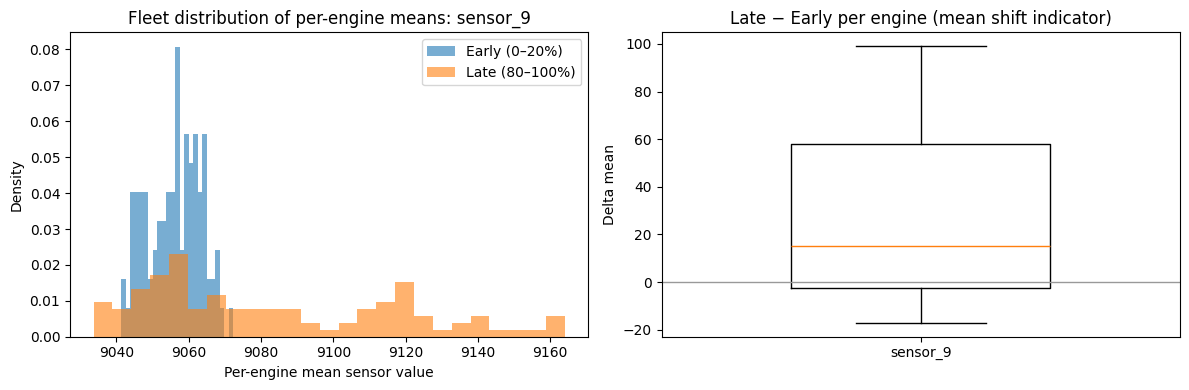

,engine_id,early_mean,late_mean,delta_mean
count,100.000000,100.000000,100.000000,100.000000
mean,50.500000,9056.122754,9083.770631,27.647877
std,29.011492,7.293193,35.274735,34.422390
min,1.000000,9041.386190,9033.672093,-17.104844
25%,25.750000,9050.370132,9054.778349,-2.670413
50%,50.500000,9056.715664,9073.990234,15.161966
75%,75.250000,9062.054759,9116.868027,57.793653
max,100.000000,9072.351290,9164.044419,99.044305


In [21]:
# 2) Fleet-level view: early-life vs late-life distributions (per-engine summaries for fair comparison)

early_frac = 0.20
late_frac = 0.80

# Per-engine means prevent long-lived engines from dominating the distribution
phase_rows = []
for eid, g in df.groupby("engine_id", sort=True):
    g = g[["life_frac", selected_sensor]].dropna()
    early_vals = g.loc[g["life_frac"] <= early_frac, selected_sensor]
    late_vals = g.loc[g["life_frac"] >= late_frac, selected_sensor]
    if len(early_vals) < 5 or len(late_vals) < 5:
        continue
    phase_rows.append({
        "engine_id": eid,
        "early_mean": early_vals.mean(),
        "late_mean": late_vals.mean(),
    })

phase_means = pd.DataFrame(phase_rows)
phase_means["delta_mean"] = phase_means["late_mean"] - phase_means["early_mean"]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograms: show whether late-life shifts relative to early-life (fleet diagnostic cue)
bins = 25
axes[0].hist(phase_means["early_mean"], bins=bins, alpha=0.60, label=f"Early (0–{int(early_frac*100)}%)", color="C0", density=True)
axes[0].hist(phase_means["late_mean"],  bins=bins, alpha=0.60, label=f"Late ({int(late_frac*100)}–100%)", color="C1", density=True)
axes[0].set_title(f"Fleet distribution of per-engine means: {selected_sensor}")
axes[0].set_xlabel("Per-engine mean sensor value")
axes[0].set_ylabel("Density")
axes[0].legend(loc="best")

# Boxplot of delta: interpretable direction + spread of degradation signal
axes[1].boxplot([phase_means["delta_mean"].values], widths=0.5, showfliers=False)
axes[1].axhline(0.0, color="0.6", linewidth=1)
axes[1].set_title("Late − Early per engine (mean shift indicator)")
axes[1].set_xticks([1])
axes[1].set_xticklabels([selected_sensor])
axes[1].set_ylabel("Delta mean")

plt.tight_layout()
plt.show()

phase_means[["engine_id", "early_mean", "late_mean", "delta_mean"]].describe()

In [10]:
phase_means

,engine_id,early_mean,late_mean,delta_mean
0,1,9049.832105,9044.229487,-5.602618
1,2,9053.154035,9083.465690,30.311655
2,3,9054.568286,9142.590278,88.021992
3,4,9050.832973,9141.228158,90.395185
4,5,9067.536415,9120.756111,53.219696
...,...,...,...,...
95,96,9052.243582,9067.214706,14.971124
96,97,9046.973500,9146.017805,99.044305
97,98,9068.515806,9063.278438,-5.237369
98,99,9055.692703,9057.455789,1.763087


In [15]:
# 3) Helper function (in src/utils.py): basic degradation indicators for one sensor
degradation_indicators(df, selected_sensor, early_frac=early_frac, late_frac=late_frac)

DegradationIndicators(sensor='sensor_9', mean_shift=27.647876527807004, abs_mean_shift=32.0409440027251, variance_ratio=12.99662404997461, log_variance_ratio=2.564689635273157, slope=32.90407115221724, abs_slope=37.96182387740129, baseline_std_early=8.307348177361419, mean_shift_std=3.3281229987628285, abs_mean_shift_std=3.856940063020441, slope_std=3.9608393015095986, abs_slope_std=4.569668089854725, n_engines_used_shift=100, n_engines_used_slope=100)

In [16]:
# 4) Rank sensors by degradation sensitivity (no hardcoding)

ranked = rank_sensors_by_degradation(
    df,
    sensor_cols,
    early_frac=early_frac,
    late_frac=late_frac,
    min_points_for_slope=20,
 )

ranked[[
    "sensor",
    "score",
    "abs_mean_shift_std",
    "abs_slope_std",
    "variance_ratio",
    "log_variance_ratio",
    "n_engines_used_shift",
    "n_engines_used_slope",
]].head(15)

,sensor,score,abs_mean_shift_std,abs_slope_std,variance_ratio,log_variance_ratio,n_engines_used_shift,n_engines_used_slope
8,sensor_9,10.991298,3.856940,4.569668,12.996624,2.564690,100,100
13,sensor_14,10.122650,3.412646,4.044474,14.375552,2.665529,100,100
10,sensor_11,8.109903,3.166906,3.819337,3.076093,1.123660,100,100
3,sensor_4,7.735094,3.092512,3.729967,2.490828,0.912615,100,100
11,sensor_12,7.454117,2.936888,3.549675,2.631499,0.967554,100,100
6,sensor_7,6.924945,2.773590,3.349662,2.229313,0.801694,100,100
14,sensor_15,6.659345,2.717926,3.287331,1.923387,0.654088,100,100
19,sensor_20,6.471334,2.655059,3.205313,1.842204,0.610963,100,100
20,sensor_21,6.344131,2.628177,3.158562,1.746114,0.557392,100,100
16,sensor_17,6.050417,2.491239,3.000853,1.747743,0.558325,100,100


# Rule-Based Diagnostics – Summary of Findings

This notebook explored **rule-based degradation diagnostics** using the C-MAPSS FD001 dataset.  
The goal was to identify **which sensors reliably reflect engine degradation**, and **why**, using interpretable, physics-aligned indicators instead of black-box models.

---

### 1. Operating Conditions Validation

- The operational settings (`op_setting_1`, `op_setting_2`, `op_setting_3`) were analyzed to determine whether engines operate under multiple regimes.
- Although `op_setting_1` and `op_setting_2` show many unique floating-point values, their ranges and standard deviations are extremely small.
- These variations are attributable to **numerical noise**, not real operating regime changes.
- `op_setting_3` is strictly constant.

**Conclusion**  
FD001 represents a **single operating condition dataset**, meaning:
- Sensor trends are not confounded by regime changes
- Sensor behavior can be compared **directly across engines**
- Degradation signals are easier to interpret

---

### 2. Single-Engine Diagnostics (Time-Series View – Sensor 9)

To understand how degradation manifests over time at the individual engine level, a detailed time-series analysis was performed **specifically for `sensor_9`**, which later emerged as the strongest degradation indicator at the fleet level.

For a representative engine, rolling statistics were computed:

- **Rolling mean** – to extract slow degradation drift while suppressing cycle-to-cycle noise  
- **Rolling standard deviation** – to capture local instability and noise growth without assuming abrupt fault onset  

The rolling window was chosen as a fraction of engine life to balance noise suppression and trend visibility, ensuring the analysis adapts to different engine lifetimes.

### Observations

- The **rolling mean of sensor_9** remains relatively stable during early life and begins a gradual upward drift as the engine ages.
- Toward late life, this drift **accelerates**, indicating progressive degradation rather than random fluctuation.
- The **rolling standard deviation of sensor_9** remains low and stable in early life but increases noticeably near end-of-life.
- This increase in variability suggests **growing instability and reduced control margin**, which commonly precede failure.

### Interpretation

For `sensor_9`, degradation is expressed through a **two-stage pattern**:
1. A slow, monotonic increase in the sensor level (mean drift)
2. A subsequent rise in local variability (instability growth)

This behavior is consistent with wear-driven degradation mechanisms and provides strong motivation for using `sensor_9` as a diagnostic and prognostic feature.

**Conclusion**  
Single-engine analysis confirms that `sensor_9` exhibits clear, interpretable degradation dynamics at the time-series level, supporting its high ranking in subsequent fleet-level and quantitative analyses.


---

### 3. Fleet-Level Early vs Late Life Analysis

To avoid bias from engines with longer lifetimes:
- Each engine was summarized using:
  - `early_mean` (first 20% of life)
  - `late_mean` (last 20% of life)
- One value per engine ensures **fair fleet comparison**.

### Fleet Distributions
- Histograms of per-engine means show:
  - early-life distributions concentrated on the left
  - late-life distributions shifted to the right
- This indicates a **systematic fleet-wide increase** in sensor values with age.

### Delta Mean (`late_mean − early_mean`)
- Boxplots show:
  - median clearly above zero
  - wide spread (engine-to-engine variability)
  - a few negative values, expected due to noise or weak sensitivity

**Conclusion**  
Across the fleet, many sensors show a **consistent directional degradation trend**, not driven by a few outliers.

---

### 4. Degradation Indicators (Quantitative Summary)

For each sensor, the following interpretable indicators were computed:

- **Mean shift** – change in average sensor level
- **Slope** – rate of change over life
- **Variance ratio** – growth in instability
- **Baseline normalization** – all effects expressed relative to early-life noise

These metrics were also computed in **absolute and standardized (signal-to-noise)** form.

### Example: Sensor 9
Sensor 9 shows:
- Strong positive mean shift
- Large increase in variance (≈13×)
- High slope relative to baseline noise
- Consistent behavior across all engines

**Interpretation**  
Sensor 9 clearly reflects degradation in:
- level
- trend
- stability  
making it a high-quality diagnostic and prognostic sensor.

---

### 5. Sensor Ranking by Degradation Strength

Sensors were ranked using a composite score combining:
- normalized mean shift
- normalized slope
- log variance ratio
- fleet consistency

### Key Results
- **Top-ranked sensors (e.g., sensor_9, sensor_14)**:
  - strong signal-to-noise ratios
  - clear degradation trends
  - high instability growth
- **Mid-ranked sensors**:
  - useful as supporting indicators
- **Low-ranked sensors**:
  - weak or noisy degradation response

All rankings used **100 engines**, ensuring stability and fairness.

**Conclusion**  
A small subset of sensors carry most of the degradation information.  
These sensors are ideal candidates for:
- anomaly detection
- health indicators
- RUL modeling

---

### 6. Overall Conclusions

- FD001 is a clean, single-regime dataset suitable for interpretable diagnostics.
- Degradation manifests as:
  - slow mean drift
  - increasing variability
  - heterogeneous severity across engines
- Rule-based indicators successfully identify:
  - which sensors degrade
  - how strongly
  - how consistently across the fleet
- Sensor 9 emerges as the strongest degradation indicator, with several others forming a reliable diagnostic subset.

**Final Takeaway**  
Rule-based, signal-to-noise–aware diagnostics provide a transparent and physically meaningful foundation for industrial health monitoring, and form a strong basis for subsequent machine-learning models.

